In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

In [ ]:
# !pip install --quiet missingno
# !pip install --quiet lightgbm

In [137]:
import os
# os.chdir(r"/content/drive/MyDrive/billing_features/raw/")
import math
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import missingno as msno
import pickle
import lightgbm
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score,average_precision_score
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import auc as auc_score
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [138]:
data_dir=os.getcwd()
os.listdir()

['PolicyPremium_Combined.csv',
 'Data Dictionary v4.xlsx',
 'Anniv_RG_Data_POLICY_2017_2022YTD.txt',
 'buffer_0.ipynb',
 'Trident_Data_Explore_0708.ipynb',
 'Trident_Data_Explore_0709.ipynb',
 'churn_labels.csv',
 'Trident_Data_Explore_v3.ipynb',
 'Trident_Data_Explore_0715.ipynb',
 'Trident_Data_Explore_0714.ipynb']

In [72]:
start=time.time()
policy_premium_df = pd.read_csv(os.path.join(data_dir,'PolicyPremium_Combined.csv'))
end=time.time()
print("running time {:.4f}".format(end-start))
policy_premium_df.shape

running time 9.1942


(3626285, 25)

In [73]:
churn_labels = pd.read_csv('churn_labels.csv')
churn_labels.dropna(subset=['churn'],inplace=True)
churn_labels.shape

(456829, 9)

In [74]:
policy_id=np.unique(churn_labels['policy_id'].values)
policy_id.shape

(115418,)

In [75]:
policy_premium_df=policy_premium_df[policy_premium_df["policy_id"].isin(policy_id)]
policy_premium_df.shape

(3620385, 25)

In [76]:
policy_premium_df['year']  = policy_premium_df.bill_due_dt.apply(lambda x: x[:4])
policy_premium_df['month'] = policy_premium_df.bill_due_dt.apply(lambda x: x[5:7])
policy_premium_df['policy_id']=policy_premium_df['policy_id'].astype(int)
policy_premium_df['year']=policy_premium_df['year'].apply(str)
policy_premium_df['month']=policy_premium_df['month'].apply(str)
policy_premium_df.drop(['Unnamed: 0','report_start_dt','report_end_dt','bill_due_dt','bill_gen_dt'], axis=1, inplace=True)
policy_premium_df=policy_premium_df.reset_index(drop=True)

In [77]:
pd.set_option('display.max_columns', None)
policy_premium_df.loc[policy_premium_df.policy_id==607176].head()

,policy_id,CountBills,CountBillGens,CountFirstGenBillsPaidFull,CountBillsPaidFull,CountBillsPaid,OrigBillAmt,CurrBillAmt,CurrPaidAmt,PaidBillDueDays,AvgPdBilldueDays,PaidBillLastGenDays,AvgPdBillLstGenDays,AvgBillGenCnt,AvgPaidFullCnt,AvgFirstGenPaidFullCnt,Lag12_cntBillGens,Lag12_cntPaidFull,Lag12_cntFirstGenPaidFull,Lag12_cntBills,year,month
0,607176,1,1,1,1,1,211.31,211.31,211.31,-4,-4.0,14,14.0,1.0,1.0,1.0,13.0,12.0,11.0,12.0,2020,11
28969,607176,1,1,1,1,1,190.98,190.98,190.98,-10,-10.0,8,8.0,1.0,1.0,1.0,11.0,11.0,11.0,11.0,2018,12
40576,607176,1,1,1,1,1,190.98,190.98,190.98,-10,-10.0,8,8.0,1.0,1.0,1.0,8.0,8.0,8.0,8.0,2018,09
168537,607176,1,1,1,1,1,154.70,154.70,154.70,66,66.0,9,9.0,1.0,1.0,1.0,13.0,12.0,11.0,12.0,2020,03
174517,607176,1,1,1,1,1,190.98,190.98,190.98,-5,-5.0,13,13.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,2018,01


In [78]:
policy_premium_df = policy_premium_df.replace('?', np.nan)
policy_premium_df["AvgPdBilldueDays"]=policy_premium_df["AvgPdBilldueDays"].astype(float)
policy_premium_df["AvgPdBillLstGenDays"]=policy_premium_df["AvgPdBillLstGenDays"].astype(float)
policy_premium_df["Lag12_cntBillGens"]=policy_premium_df["Lag12_cntBillGens"].astype(float)
policy_premium_df["Lag12_cntPaidFull"]=policy_premium_df["Lag12_cntPaidFull"].astype(float)
policy_premium_df["Lag12_cntFirstGenPaidFull"]=policy_premium_df["Lag12_cntFirstGenPaidFull"].astype(float)
policy_premium_df["Lag12_cntBills"]=policy_premium_df["Lag12_cntBills"].astype(float)

policy_premium_df['CountBills'] = policy_premium_df['CountBills'].replace(0, np.nan)
policy_premium_df['AvgPdBilldueDays'] = policy_premium_df['AvgPdBilldueDays'].replace(0, np.nan)
policy_premium_df['AvgPdBillLstGenDays'] = policy_premium_df['AvgPdBillLstGenDays'].replace(0, np.nan)
policy_premium_df['AvgBillGenCnt'] = policy_premium_df['AvgBillGenCnt'].replace(0, np.nan)
policy_premium_df['AvgPaidFullCnt'] = policy_premium_df['AvgPaidFullCnt'].replace(0, np.nan)

In [79]:
# policy_premium_df.isnull().sum().sort_values(ascending=False)/len(policy_premium_df)

pd.set_option('display.max_columns', None,'display.max_rows', None)
tempt=pd.DataFrame(policy_premium_df.isnull().sum().sort_values(ascending=False)/len(policy_premium_df)).reset_index()
tempt=tempt[tempt[0]>0]
tempt.rename({"index":"variable",0:"missing %"},axis=1).style.format({"missing %":"{:.2%}"})

,variable,missing %
0,AvgPdBillLstGenDays,8.61%
1,AvgPdBilldueDays,4.98%
2,Lag12_cntBills,3.05%
3,Lag12_cntFirstGenPaidFull,3.05%
4,Lag12_cntPaidFull,3.05%
5,Lag12_cntBillGens,3.05%
6,AvgPaidFullCnt,2.68%


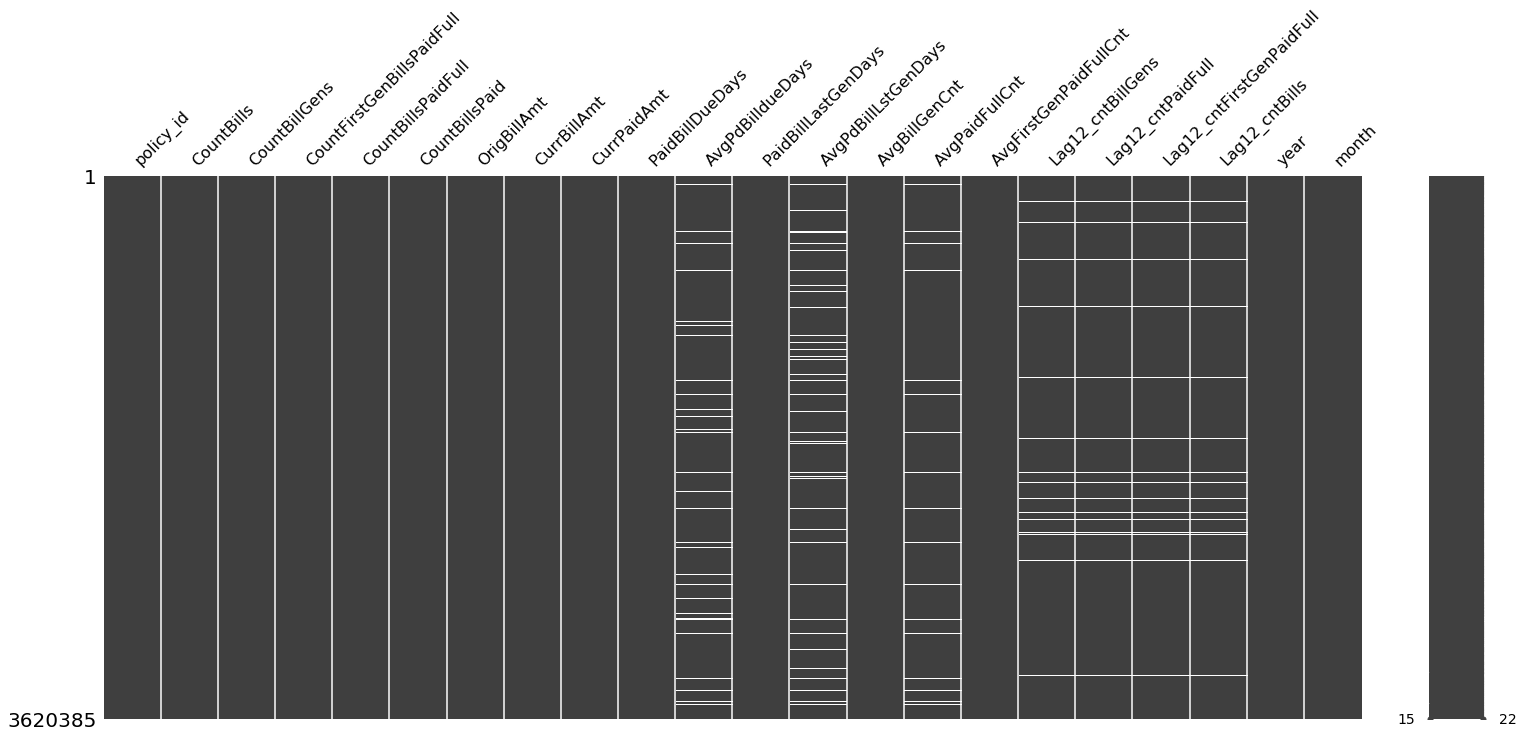

In [80]:
msno.matrix(policy_premium_df)

In [81]:
my_imputer = SimpleImputer()
numeric_columns=[]
categorical_columns=[]
for c in policy_premium_df.columns:
    if policy_premium_df[c].dtypes!="object":
        numeric_columns.append(c)
    else:
        categorical_columns.append(c)

data_numeric=policy_premium_df.loc[:,numeric_columns]
data_numeric=pd.DataFrame(my_imputer.fit_transform(data_numeric),columns=numeric_columns)

data_categorical=policy_premium_df.loc[:,categorical_columns]
policy_premium_df = pd.concat([data_numeric, data_categorical], axis = 1)

In [82]:
policy_premium_df.isnull().sum().sort_values(ascending=False)/len(policy_premium_df)

policy_id                     0.0
CountBills                    0.0
year                          0.0
Lag12_cntBills                0.0
Lag12_cntFirstGenPaidFull     0.0
Lag12_cntPaidFull             0.0
Lag12_cntBillGens             0.0
AvgFirstGenPaidFullCnt        0.0
AvgPaidFullCnt                0.0
AvgBillGenCnt                 0.0
AvgPdBillLstGenDays           0.0
PaidBillLastGenDays           0.0
AvgPdBilldueDays              0.0
PaidBillDueDays               0.0
CurrPaidAmt                   0.0
CurrBillAmt                   0.0
OrigBillAmt                   0.0
CountBillsPaid                0.0
CountBillsPaidFull            0.0
CountFirstGenBillsPaidFull    0.0
CountBillGens                 0.0
month                         0.0
dtype: float64

In [83]:
policy_premium_df['policy_id']=policy_premium_df['policy_id'].astype(int)
policy_premium_df['year']=policy_premium_df['year'].apply(int)
policy_premium_df['month']=policy_premium_df['month'].apply(int)

- $\frac{1}{T}\sum_{i=0}^{T}X_{t-i} \;\;\; T=1,2,3,6,12$
<br/><br/>
- $delta=X_t-X_{t-i} \;\;\; i=1,2,3,6,12$
<br/><br/>
- $ratio=\frac{X_t-X_{t-i}}{X_t} \;\;\; i=1,2,3,6,12$

In [84]:
def policy_df_accumulate(df):
    df.sort_values(['policy_id','year','month'],inplace=True)
    df["paid_bill_prop"]=df['CurrPaidAmt'].astype(float)/df['CurrBillAmt'].astype(float)
    # df["idx"]=df.groupby(['policy_id',"year"]).ngroup()
    exc_col=["policy_id","Lag12_cntBillGens","Lag12_cntPaidFull","Lag12_cntFirstGenPaidFull","Lag12_cntBills","year","month"]
    for col in tqdm(df.columns):
        if col not in exc_col:
            if col not in ["OrigBillAmt","CurrBillAmt","CurrPaidAmt","PaidBillDueDays","AvgPdBilldueDays","PaidBillLastGenDays","AvgPdBillLstGenDays","paid_bill_prop"]:
                df["L12_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(12, min_periods=1).sum()))
                df["L6_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(6, min_periods=1).sum()))
                df["L1_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(1, min_periods=1).sum()))
                df["L2_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(2, min_periods=1).sum()))
                df["L3_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(3, min_periods=1).sum()))
            else:
                df["L12_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(12, min_periods=1).mean()))
                df["L6_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(6, min_periods=1).mean()))
                df["L1_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(1, min_periods=1).mean()))
                df["L2_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(2, min_periods=1).mean()))
                df["L3_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(3, min_periods=1).mean()))  
                
#                 df["std12_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(12, min_periods=1).std()))
#                 df["std6_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(6, min_periods=1).std()))
#                 df["std1_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(1, min_periods=1).std()))
#                 df["std2_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(2, min_periods=1).std()))
#                 df["std3_"+col]=(df.groupby(["policy_id"])[col].apply(lambda x: x.rolling(3, min_periods=1).std()))
                
        if col not in ["policy_id","year","month"]:
            df["lag1_"+col]=df[col].shift(1)
            df["d1_"+col]=df[col]-df["lag1_"+col]
            df["r1_"+col]=(df[col]-df["lag1_"+col])/df["lag1_"+col]
            df.drop(["lag1_"+col],axis=1,inplace=True)
            
            df["lag2_"+col]=df[col].shift(2)
            df["d2_"+col]=df[col]-df["lag2_"+col]
            df["r2_"+col]=(df[col]-df["lag2_"+col])/df["lag2_"+col]
            df.drop(["lag2_"+col],axis=1,inplace=True)

            df["lag3_"+col]=df[col].shift(3)
            df["d3_"+col]=df[col]-df["lag3_"+col]
            df["r3_"+col]=(df[col]-df["lag3_"+col])/df["lag3_"+col]
            df.drop(["lag3_"+col],axis=1,inplace=True)
            
            df["lag6_"+col]=df[col].shift(6)
            df["d6_"+col]=df[col]-df["lag6_"+col]
            df["r6_"+col]=(df[col]-df["lag6_"+col])/df["lag6_"+col]
            df.drop(["lag6_"+col],axis=1,inplace=True)
            
            df["lag12_"+col]=df[col].shift(12)
            df["d12_"+col]=df[col]-df["lag12_"+col]
            df["r12_"+col]=(df[col]-df["lag12_"+col])/df["lag12_"+col]
            df.drop(["lag12_"+col],axis=1,inplace=True)
            
    # df.drop(['idx'],axis=1,inplace=True) 
               
    return df

In [ ]:
df=policy_df_accumulate(policy_premium_df)

In [ ]:
file_output="policy_premium_pickle"
data_dir="/app/models/dij22"
df.to_pickle(os.path.join(data_dir,file_output))

# file_output="policy_premium.csv"
# data_dir="/home/dij22/Trident"
# df.to_csv(os.path.join(data_dir,file_output))

In [139]:
file="policy_premium_pickle"
data_dir="/app/models/dij22"
policy_premium_df=pd.read_pickle(os.path.join(data_dir,file))

# start=time.time()
# file_output="policy_premium.csv"
# policy_premium_df=pd.read_csv(os.path.join(data_dir,file))
# end=time.time()
# print("running time {:.4f}".format(end-start))

In [140]:
pd.set_option('display.max_columns', None)
policy_premium_df.head()

,policy_id,CountBills,CountBillGens,CountFirstGenBillsPaidFull,CountBillsPaidFull,CountBillsPaid,OrigBillAmt,CurrBillAmt,CurrPaidAmt,PaidBillDueDays,AvgPdBilldueDays,PaidBillLastGenDays,AvgPdBillLstGenDays,AvgBillGenCnt,AvgPaidFullCnt,AvgFirstGenPaidFullCnt,Lag12_cntBillGens,Lag12_cntPaidFull,Lag12_cntFirstGenPaidFull,Lag12_cntBills,year,month,paid_bill_prop,L12_CountBills,L6_CountBills,L1_CountBills,L2_CountBills,L3_CountBills,d1_CountBills,r1_CountBills,d2_CountBills,r2_CountBills,d3_CountBills,r3_CountBills,d6_CountBills,r6_CountBills,d12_CountBills,r12_CountBills,L12_CountBillGens,L6_CountBillGens,L1_CountBillGens,L2_CountBillGens,L3_CountBillGens,d1_CountBillGens,r1_CountBillGens,d2_CountBillGens,r2_CountBillGens,d3_CountBillGens,r3_CountBillGens,d6_CountBillGens,r6_CountBillGens,d12_CountBillGens,r12_CountBillGens,L12_CountFirstGenBillsPaidFull,L6_CountFirstGenBillsPaidFull,L1_CountFirstGenBillsPaidFull,L2_CountFirstGenBillsPaidFull,L3_CountFirstGenBillsPaidFull,d1_CountFirstGenBillsPaidFull,r1_CountFirstGenBillsPaidFull,d2_CountFirstGenBillsPaidFull,r2_CountFirstGenBillsPaidFull,d3_CountFirstGenBillsPaidFull,r3_CountFirstGenBillsPaidFull,d6_CountFirstGenBillsPaidFull,r6_CountFirstGenBillsPaidFull,d12_CountFirstGenBillsPaidFull,r12_CountFirstGenBillsPaidFull,L12_CountBillsPaidFull,L6_CountBillsPaidFull,L1_CountBillsPaidFull,L2_CountBillsPaidFull,L3_CountBillsPaidFull,d1_CountBillsPaidFull,r1_CountBillsPaidFull,d2_CountBillsPaidFull,r2_CountBillsPaidFull,d3_CountBillsPaidFull,r3_CountBillsPaidFull,d6_CountBillsPaidFull,r6_CountBillsPaidFull,d12_CountBillsPaidFull,r12_CountBillsPaidFull,L12_CountBillsPaid,L6_CountBillsPaid,L1_CountBillsPaid,L2_CountBillsPaid,L3_CountBillsPaid,d1_CountBillsPaid,r1_CountBillsPaid,d2_CountBillsPaid,r2_CountBillsPaid,d3_CountBillsPaid,r3_CountBillsPaid,d6_CountBillsPaid,r6_CountBillsPaid,d12_CountBillsPaid,r12_CountBillsPaid,L12_OrigBillAmt,L6_OrigBillAmt,L1_OrigBillAmt,L2_OrigBillAmt,L3_OrigBillAmt,d1_OrigBillAmt,r1_OrigBillAmt,d2_OrigBillAmt,r2_OrigBillAmt,d3_OrigBillAmt,r3_OrigBillAmt,d6_OrigBillAmt,r6_OrigBillAmt,d12_OrigBillAmt,r12_OrigBillAmt,L12_CurrBillAmt,L6_CurrBillAmt,L1_CurrBillAmt,L2_CurrBillAmt,L3_CurrBillAmt,d1_CurrBillAmt,r1_CurrBillAmt,d2_CurrBillAmt,r2_CurrBillAmt,d3_CurrBillAmt,r3_CurrBillAmt,d6_CurrBillAmt,r6_CurrBillAmt,d12_CurrBillAmt,r12_CurrBillAmt,L12_CurrPaidAmt,L6_CurrPaidAmt,L1_CurrPaidAmt,L2_CurrPaidAmt,L3_CurrPaidAmt,d1_CurrPaidAmt,r1_CurrPaidAmt,d2_CurrPaidAmt,r2_CurrPaidAmt,d3_CurrPaidAmt,r3_CurrPaidAmt,d6_CurrPaidAmt,r6_CurrPaidAmt,d12_CurrPaidAmt,r12_CurrPaidAmt,L12_PaidBillDueDays,L6_PaidBillDueDays,L1_PaidBillDueDays,L2_PaidBillDueDays,L3_PaidBillDueDays,d1_PaidBillDueDays,r1_PaidBillDueDays,d2_PaidBillDueDays,r2_PaidBillDueDays,d3_PaidBillDueDays,r3_PaidBillDueDays,d6_PaidBillDueDays,r6_PaidBillDueDays,d12_PaidBillDueDays,r12_PaidBillDueDays,L12_AvgPdBilldueDays,L6_AvgPdBilldueDays,L1_AvgPdBilldueDays,L2_AvgPdBilldueDays,L3_AvgPdBilldueDays,d1_AvgPdBilldueDays,r1_AvgPdBilldueDays,d2_AvgPdBilldueDays,r2_AvgPdBilldueDays,d3_AvgPdBilldueDays,r3_AvgPdBilldueDays,d6_AvgPdBilldueDays,r6_AvgPdBilldueDays,d12_AvgPdBilldueDays,r12_AvgPdBilldueDays,L12_PaidBillLastGenDays,L6_PaidBillLastGenDays,L1_PaidBillLastGenDays,L2_PaidBillLastGenDays,L3_PaidBillLastGenDays,d1_PaidBillLastGenDays,r1_PaidBillLastGenDays,d2_PaidBillLastGenDays,r2_PaidBillLastGenDays,d3_PaidBillLastGenDays,r3_PaidBillLastGenDays,d6_PaidBillLastGenDays,r6_PaidBillLastGenDays,d12_PaidBillLastGenDays,r12_PaidBillLastGenDays,L12_AvgPdBillLstGenDays,L6_AvgPdBillLstGenDays,L1_AvgPdBillLstGenDays,L2_AvgPdBillLstGenDays,L3_AvgPdBillLstGenDays,d1_AvgPdBillLstGenDays,r1_AvgPdBillLstGenDays,d2_AvgPdBillLstGenDays,r2_AvgPdBillLstGenDays,d3_AvgPdBillLstGenDays,r3_AvgPdBillLstGenDays,d6_AvgPdBillLstGenDays,r6_AvgPdBillLstGenDays,d12_AvgPdBillLstGenDays,r12_AvgPdBillLstGenDays,L12_AvgBillGenCnt,L6_AvgBillGenCnt,L1_AvgBillGenCnt,L2_AvgBillGenCnt,L3_AvgBillGenCnt,d1_AvgBillGenCnt,r1_AvgBillGenCnt,d2_AvgBillGenCnt,r

In [141]:
policy_premium_df.shape

(3620385, 303)

In [143]:
churn_labels = pd.read_csv('churn_labels.csv')
# churn_labels['policy_id']=churn_labels['policy_id'].astype(int)
# churn_labels['year']=churn_labels['year'].apply(int)
churn_labels.shape

(456829, 9)

In [144]:
def pivot_date(df,buffer):
    policy_id=[]
    year=[]
    month=[]
    pivot_date=[]
    policy_year=[]
    churn=[]
    for index,row in tqdm(df.iterrows(), total=df.shape[0]):
        if np.isnan(row["policy_term_month"]):
            date1=str(row["year"])+str(int(row["policy_eff_month"]))
        else:
            date1=str(row["year"])+str(int(row["policy_term_month"]))
        
        date2=pd.to_datetime(str(date1),format="%Y%m")-pd.offsets.DateOffset(months=buffer)
        policy_id.append(row["policy_id"])
        year.append(date2.year)
        month.append(date2.month)
        
        if int(date1[4:])<10:
            date1=date1[:4]+str(0)+date1[4:]
        pivot_date.append(date1)
        policy_year.append(row["policy_year"])
        churn.append(row["churn"])
    churn_data=pd.DataFrame({"policy_id":policy_id,"pivot_date":pivot_date,"year":year,"month":month,"policy_year":policy_year,"churn":churn})
    # churn_data["month"]=output["month"].apply(lambda x: str(x) if x>=10 else str(0)+str(x))
    churn_data['policy_id']=churn_data['policy_id'].astype(int)
    churn_data['year']=churn_data['year'].apply(int)
    churn_data['month']=churn_data['month'].apply(int)
    return churn_data

In [145]:
churn_data=pivot_date(churn_labels,buffer=3)

100%|██████████| 456829/456829 [03:17<00:00, 2310.85it/s]


In [146]:
# var=policy_premium_df.columns[:50].tolist()
# tempt=policy_premium_df.loc[:,var]
# df=pd.merge(churn_data,tempt,how="inner", on=["policy_id", "year","month"])
start=time.time()
df=pd.merge(churn_data,policy_premium_df,how="inner", on=["policy_id", "year","month"])
end=time.time()
print("running time {:.4f}".format(end-start))

running time 17.0059


### Data Exploration

In [157]:
col=['policy_id',
     'year',
     'month',
'policy_year',
 'Lag12_cntBills',
 'PaidBillLastGenDays',
 'OrigBillAmt',
 'AvgPdBilldueDays',
 'CurrBillAmt',
 'CurrPaidAmt',
 'AvgPdBillLstGenDays',
 'Lag12_cntBillGens',
 'PaidBillDueDays',
 'Lag12_cntFirstGenPaidFull',
 'Lag12_cntPaidFull',
 'CountFirstGenBillsPaidFull',
 'CountBillGens',
 'CountBills',
 'CountBillsPaid',
 'AvgFirstGenPaidFullCnt',
 'CountBillsPaidFull',
 'AvgBillGenCnt',
 'AvgPaidFullCnt',
 'churn']


orig_data=df.loc[:,col]
IDX=[]
for index,row in tqdm(orig_data.iterrows(), total=orig_data.shape[0]):
    # for c in col:
    #     if c not in ['policy_id','year','month',"churn"]:
    if row["churn"]==0 and row["CurrPaidAmt"]==0:
        IDX.append(row['policy_id'])
        
len(IDX)
            

100%|██████████| 283780/283780 [00:16<00:00, 16998.93it/s]


2205

In [158]:
pd.set_option('display.max_columns', None)
df[df.policy_id==IDX[0]].loc[:,col]

,policy_id,year,month,policy_year,Lag12_cntBills,PaidBillLastGenDays,OrigBillAmt,AvgPdBilldueDays,CurrBillAmt,CurrPaidAmt,AvgPdBillLstGenDays,Lag12_cntBillGens,PaidBillDueDays,Lag12_cntFirstGenPaidFull,Lag12_cntPaidFull,CountFirstGenBillsPaidFull,CountBillGens,CountBills,CountBillsPaid,AvgFirstGenPaidFullCnt,CountBillsPaidFull,AvgBillGenCnt,AvgPaidFullCnt,churn
164,952850,2019,1,2,9.0,0.0,285.60,91.00000,285.60,285.60,24.831786,9.0,91.0,0.0,9.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.000000,0
165,952850,2020,1,3,12.0,35.0,208.15,98.00000,208.15,208.15,35.000000,12.0,98.0,0.0,12.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.000000,0
166,952850,2021,1,4,12.0,0.0,142.45,22.20817,142.45,0.00,24.831786,12.0,0.0,0.0,12.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.997892,0
167,952850,2022,1,5,10.0,45.0,160.70,107.00000,160.70,160.70,45.000000,10.0,107.0,0.0,10.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.000000,0


In [92]:
# file_output="df_pickle"
# data_dir="/app/models/dij22"
# df.to_pickle(os.path.join(data_dir,file_output))

In [93]:
# file="df_pickle"
# data_dir="/app/models/dij22"
# df=pd.read_pickle(os.path.join(data_dir,file))

In [94]:
df.shape

(283780, 306)

In [95]:
var=["policy_id","pivot_date","year","month","policy_year","churn","CurrPaidAmt","L3_CurrPaidAmt","L6_CurrPaidAmt","L12_CurrPaidAmt"]
df[df.policy_id==151353].loc[:,var]

,policy_id,pivot_date,year,month,policy_year,churn,CurrPaidAmt,L3_CurrPaidAmt,L6_CurrPaidAmt,L12_CurrPaidAmt
652,151353,201804,2018,1,10,0,200.75,200.750000,200.750000,200.750000
653,151353,201904,2019,1,11,0,200.75,200.750000,167.291667,184.020833
654,151353,202004,2020,1,12,0,200.75,200.750000,200.750000,200.750000
655,151353,202104,2021,1,13,1,162.25,149.416667,155.833333,158.583333


In [96]:
var=["policy_id","year","month","CountBillsPaidFull","CountBillsPaid" ,"CurrPaidAmt","L3_CurrPaidAmt","L6_CurrPaidAmt","L12_CurrPaidAmt"]
policy_premium_df[policy_premium_df.policy_id==151353].loc[:,var]

,policy_id,year,month,CountBillsPaidFull,CountBillsPaid,CurrPaidAmt,L3_CurrPaidAmt,L6_CurrPaidAmt,L12_CurrPaidAmt
1542281,151353,2018,1,1.0,1.0,200.75,200.750000,200.750000,200.750000
1247002,151353,2018,2,1.0,1.0,200.75,200.750000,200.750000,200.750000
238759,151353,2018,3,1.0,1.0,200.75,200.750000,200.750000,200.750000
2390473,151353,2018,4,1.0,1.0,200.75,200.750000,200.750000,200.750000
1633907,151353,2018,5,1.0,1.0,200.75,200.750000,200.750000,200.750000
1139574,151353,2018,6,1.0,1.0,200.75,200.750000,200.750000,200.750000
349779,151353,2018,7,1.0,1.0,200.75,200.750000,200.750000,200.750000
2452932,151353,2018,8,1.0,1.0,200.75,200.750000,200.750000,200.750000
1882119,151353,2018,9,1.0,1.0,200.75,200.750000,200.750000,200.750000
1140361,151353,2018,10,0.0,0.0,0.00,133.833333,167.291667,180.675000


In [97]:
var=["policy_id","year","policy_eff_month","policy_term_month","policy_year","churn"]
churn_labels[churn_labels.policy_id==151353].loc[:,var]

,policy_id,year,policy_eff_month,policy_term_month,policy_year,churn
1065,151353.0,2017,4,4.0,9,0
1066,151353.0,2018,4,4.0,10,0
1067,151353.0,2019,4,4.0,11,0
1068,151353.0,2020,4,4.0,12,0
1069,151353.0,2021,4,4.0,13,1


In [98]:
pd.set_option('display.max_columns', None,'display.max_rows', None)
tempt=pd.DataFrame(policy_premium_df.isnull().sum().sort_values(ascending=False)/len(policy_premium_df)).reset_index()
tempt=tempt[tempt[0]>0]
tempt.rename({"index":"variable",0:"missing %"},axis=1).style.format({"missing %":"{:.4%}"})

,variable,missing %
0,r1_CountFirstGenBillsPaidFull,19.7002%
1,r1_AvgFirstGenPaidFullCnt,19.7002%
2,r2_CountFirstGenBillsPaidFull,18.6482%
3,r2_AvgFirstGenPaidFullCnt,18.6482%
4,r3_AvgFirstGenPaidFullCnt,18.0221%
5,r3_CountFirstGenBillsPaidFull,18.0221%
6,r6_AvgFirstGenPaidFullCnt,16.8084%
7,r6_CountFirstGenBillsPaidFull,16.8084%
8,r1_Lag12_cntFirstGenPaidFull,16.6559%
9,r2_Lag12_cntFirstGenPaidFull,16.2465%


In [99]:
df2=df.copy()
df2.dropna(axis = 0, how ='any',inplace=True)
df2.shape

(227406, 306)

In [100]:
print("{:.2%} data was drop".format(1-df2.shape[0]/df.shape[0]))

19.87% data was drop


In [101]:
df2["churn"].value_counts(dropna=False, normalize=True).to_frame().style.format({"churn":"{:.2%}"})

,churn
0,92.63%
1,7.37%


No handles with labels found to put in legend.


<Figure size 720x576 with 0 Axes>

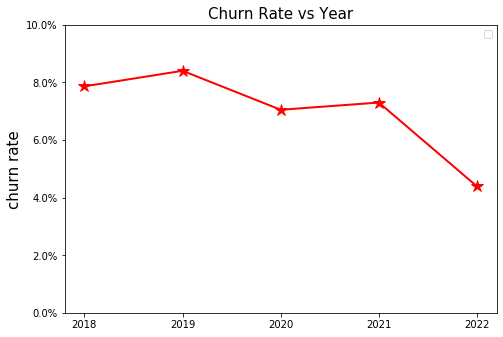

In [102]:
churn_year=df2.groupby(['year']).mean().reset_index().loc[:,["year","churn"]]
churn_year.style.format({"churn":"{.2%}"})

plt.figure(figsize=(10,8))
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1]) # main axes
ax.plot(churn_year["year"],churn_year["churn"],color="r",marker="*",linewidth=2, markersize=12)
ax.set_title("Churn Rate vs Year",fontsize=15)
ax.legend()
ax.set_ylabel("churn rate",fontsize=15)
ax.set_xticks([2018,2019,2020,2021,2022])
ax.set_ylim([0,0.1])
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
plt.show()

In [ ]:
# # Changing option to use infinite as nan
# pd.set_option('mode.use_inf_as_na', True)
  
# # Dropping all the rows with nan values
# df.dropna(inplace=True)

In [ ]:
# my_imputer = SimpleImputer()
# numeric_columns=[]
# categorical_columns=[]
# for c in df.columns:
#     if df[c].dtypes!="object":
#         numeric_columns.append(c)
#     else:
#         categorical_columns.append(c)

# data_numeric=df.loc[:,numeric_columns]
# data_numeric=pd.DataFrame(my_imputer.fit_transform(data_numeric),columns=numeric_columns)

# data_categorical=df.loc[:,categorical_columns]
# df2 = pd.concat([data_numeric, data_categorical], axis = 1)

In [103]:
def model_evaluate(target, predicted):
    
    precision, recall, thresholds = precision_recall_curve(target, predicted)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    fscore=fscore[~np.isnan(fscore)]
    ix = np.argmax(fscore)
    f1_score=fscore[ix]
    

    auc=roc_auc_score(target, predicted)
    pr_auc=auc_score(recall,precision)

    thrs=thresholds[ix]
    prec=precision[ix]
    reca=recall[ix]

    true_label_mask=[1 if x>=thrs else 0 for i,x in enumerate(predicted)]

    nb_prediction=len(true_label_mask)
    true_prediction=sum(true_label_mask)
    false_prediction=nb_prediction-true_prediction
    accuracy=true_prediction/nb_prediction
    
    return {
        "nb_example":len(target),
        "true_prediction":true_prediction,
        "false_prediction":false_prediction,
        "accuracy":accuracy,
        "precision":prec, 
        "recall":reca, 
        "f1_score":f1_score,
        "AUC":auc,
        "pr_auc":pr_auc
    }

In [104]:
df3=df2.copy()
# exclude_cols=['policy_id', 'pivot_date', 'churn']
# df3["year"]=df3["year"].astype('category')
# df3["month"]=df3["month"].astype('category')

exclude_cols=['policy_id', 'pivot_date', 'churn',"year","month"]

# target=df3.loc[:,["year","churn"]]
# feature=df3.drop(exclude_cols, axis=1)
# X_train,X_test,y_train,y_test=train_test_split(feature,target,test_size=0.25,stratify=target,random_state=101)

train_data=df3[df3["year"]!=2022]
test_data=df3[df3["year"]==2022]

y_train=train_data.loc[:,"churn"]
y_test=test_data.loc[:,"churn"]
X_train=train_data.drop(exclude_cols, axis=1)
X_test=test_data.drop(exclude_cols, axis=1)


print("{:<30}{:<20,}".format('training features: ', len(X_train)))
print("{:<30}{:<20,}".format('testing features: ', len(X_test)))
# print("{:<30}{:<20,}".format('training features: ', len(y_train)))
# print("{:<30}{:<20,}".format('testing features: ', len(y_test)))
# print(y_train.value_counts(dropna=False,normalize=True).to_frame())
pd.DataFrame(y_test, columns=["churn"])["churn"].value_counts(dropna=False,normalize=True).to_frame().style.format({"churn":"{:.2%}"})

training features:            206,569             
testing features:             20,837              


,churn
0,95.61%
1,4.39%


In [105]:
# categorical_features=['year', 'month']
# train_data = lightgbm.Dataset(X_train, label=y_train,categorical_feature=categorical_features)
train_data = lightgbm.Dataset(X_train, label=y_train)
test_data = lightgbm.Dataset(X_test, label=y_test)
#basic parameter:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

# parameters = {
#     'application': 'binary',
#     'objective': 'binary',
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
#     'num_leaves': 31,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.5,
#     'bagging_freq': 20,
#     'learning_rate': 0.05,
#     'verbose': 0
# }

# from sklearn.metrics import f1_score

# def lgb_f1_score(y_hat, data):
#     y_true = data.get_label()
#     y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
#     return 'f1', f1_score(y_true, y_hat), True

# model = lightgbm.train(parameters,
#                        train_data,
#                        valid_sets=test_data,
#                        num_boost_round=5000,
#                        early_stopping_rounds=100, 
#                        feval=lgb_f1_score
#                       )

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[1]	valid_0's auc: 0.622329
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.576548
[3]	valid_0's auc: 0.560795
[4]	valid_0's auc: 0.569511
[5]	valid_0's auc: 0.588998
[6]	valid_0's auc: 0.571664
[7]	valid_0's auc: 0.570676
[8]	valid_0's auc: 0.570117
[9]	valid_0's auc: 0.575616
[10]	valid_0's auc: 0.578457
[11]	valid_0's auc: 0.581476
[12]	valid_0's auc: 0.594341
[13]	valid_0's auc: 0.594402
[14]	valid_0's auc: 0.593753
[15]	valid_0's auc: 0.59839
[16]	v

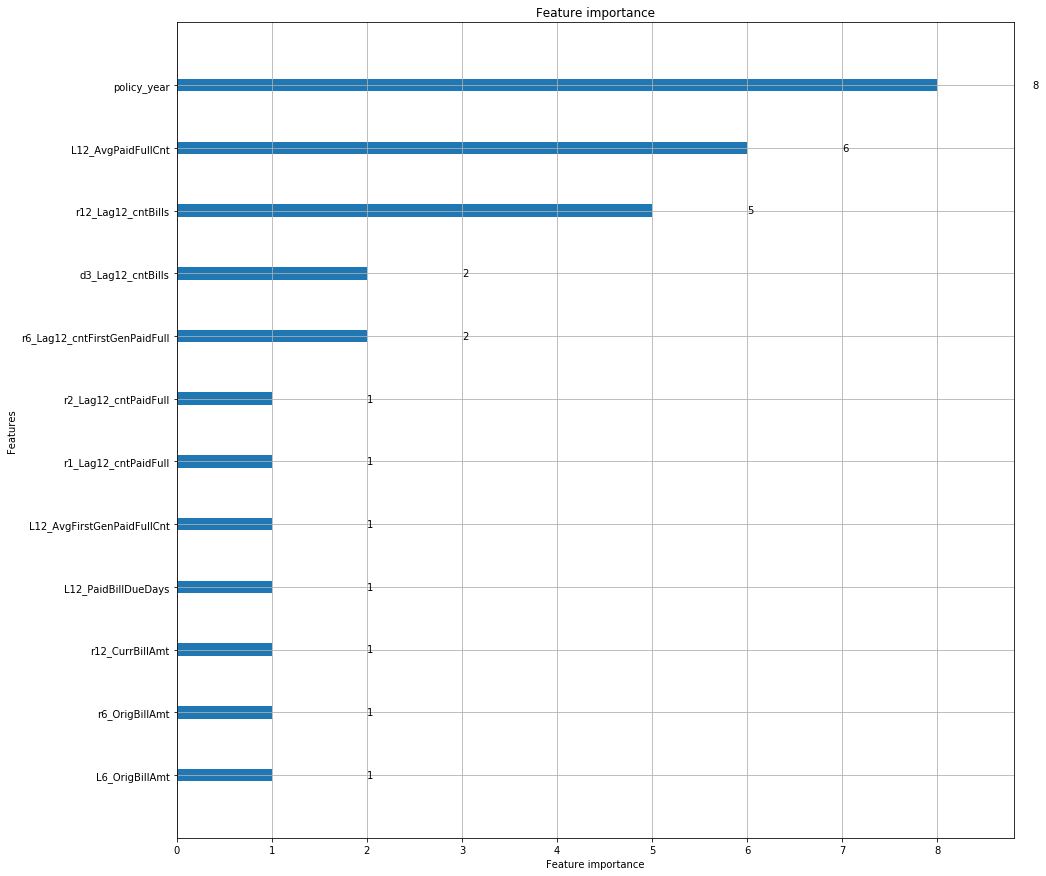

In [106]:
ax = lightgbm.plot_importance(model, max_num_features=40, figsize=(15,15))
plt.show()

In [107]:
df_feature_importance_v3 = (
    pd.DataFrame({
        'feature': model.feature_name(),
        'importance': model.feature_importance(),
    })
    .sort_values('importance', ascending=False)
)
df_feature_importance_v3["rank"]=list(range(len(model.feature_name())))
df_feature_importance_v3=df_feature_importance_v3.loc[:,["rank","feature","importance"]].reset_index(drop=True)
df_feature_importance_v3.head(20)

,rank,feature,importance
0,0,policy_year,8
1,1,L12_AvgPaidFullCnt,6
2,2,r12_Lag12_cntBills,5
3,3,r6_Lag12_cntFirstGenPaidFull,2
4,4,d3_Lag12_cntBills,2
5,5,r1_Lag12_cntPaidFull,1
6,6,L12_AvgFirstGenPaidFullCnt,1
7,7,L6_OrigBillAmt,1
8,8,L12_PaidBillDueDays,1
9,9,r2_Lag12_cntPaidFull,1


In [108]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_eval_v3=model_evaluate(y_train, train_preds)
test_eval_v3=model_evaluate(y_test, test_preds)

In [109]:
fpr_train_v3, tpr_train_v3, _ = roc_curve(y_train,  train_preds)
fpr_test_v3, tpr_test_v3, _ = roc_curve(y_test,  test_preds)

prec_train_v3, recall_train_v3, _ = precision_recall_curve(y_train,  train_preds)
prec_test_v3, recall_test_v3, _ = precision_recall_curve(y_test,  test_preds)

In [110]:
# fig = plt.subplots(nrows=1,ncols=2,figsize =(25, 10))
# plt.subplot(1, 2, 1)
# plt.plot(fpr_train_v3, tpr_train_v3, linestyle='solid', label='rolling window features + delta features', color ='purple', linewidth=2)
# plt.plot([0, 1], [0, 1], linestyle='solid', label='random model', color ='darkorange', linewidth=2)
# plt.xlabel('False Positive Rate', fontweight ='bold',fontsize=15)
# plt.ylabel('True Positive Rate', fontweight ='bold',fontsize=15)
# plt.title(f'ROC AUC CURVE \n{"Training"}', fontweight ='bold',fontsize=18)
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# # show the legend
# plt.legend(fontsize="x-large")

# plt.subplot(1, 2, 2)
# plt.plot(fpr_test_v3, tpr_test_v3, linestyle='solid', label='rolling window features + delta features', color ='purple', linewidth=2)
# plt.plot([0, 1], [0, 1], linestyle='solid', label='random model', color ='darkorange', linewidth=2)
# # axis labels
# plt.xlabel('False Positive Rate', fontweight ='bold',fontsize=15)
# plt.ylabel('True Positive Rate', fontweight ='bold',fontsize=15)
# plt.title(f'ROC AUC CURVE \n{"test"}', fontweight ='bold',fontsize=18)

# plt.xlim([0, 1])
# plt.ylim([0, 1])
# # show the legend
# plt.legend(fontsize="x-large")
# # show the plot
# plt.show()

In [111]:
# fig = plt.subplots(nrows=1,ncols=2,figsize =(25, 10))
# plt.subplot(1, 2, 1)
# plt.plot(prec_train_v3, recall_train_v3, linestyle='solid', label='rolling window features + delta features', color ='purple', linewidth=2)

# plt.xlabel('Recall', fontweight ='bold',fontsize=15)
# plt.ylabel('Precision', fontweight ='bold',fontsize=15)
# plt.title(f'Precision Recall CURVE \n{"Training"}', fontweight ='bold',fontsize=18)
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# # show the legend
# plt.legend(fontsize="x-large")

# plt.subplot(1, 2, 2)
# plt.plot(prec_test_v3, recall_test_v3, linestyle='solid', label='rolling window features + delta features', color ='purple', linewidth=2)

# # axis labels
# plt.xlabel('Recall', fontweight ='bold',fontsize=15)
# plt.ylabel('Precision', fontweight ='bold',fontsize=15)
# plt.title(f'Precision Recall CURVE \n{"test"}', fontweight ='bold',fontsize=18)

# plt.xlim([0, 1])
# plt.ylim([0, 1])
# # show the legend
# plt.legend(fontsize="x-large")
# # show the plot
# plt.show()

### Binary Analysis

In [112]:
def pcut_func(df,var,nbin=5):
    df[var]=df[var].astype(float)
    df["cut"]=pd.qcut(df[var],nbin,precision=2,duplicates="drop")
    decile=df.groupby(df["cut"])['churn'].mean().reset_index()
    decile["cut"]=decile["cut"].astype(str)
    return decile

def myplot(df,var,*args):

    fig, a = plt.subplots(len(args)//2,2,figsize=(12,2.5*len(args)))
    a=a.ravel()
    for idx,ax in enumerate(a):
      df=args[idx]
      ax.plot(df["cut"],df["churn"],color="r",marker="*",linewidth=2, markersize=12)
      ax.set_title(var[idx])
      ax.tick_params(labelrotation=45)
    fig.tight_layout()

def hist_plot(df,var,r):

    fig, a = plt.subplots(len(var)//2,2,figsize=(12,2*len(var)))
    a=a.ravel()
    for idx,ax in enumerate(a):
      
      ax.hist(df.loc[:,var[idx]], bins=20,range=r)
      ax.set_title(var[idx])
      ax.set_xlabel(var[idx])
      ax.set_ylabel("Frequency")
    fig.tight_layout()

In [113]:
# variable_list=df_feature_importance_v3['feature'].values.tolist()[0:30]

# df3=df2.copy()

# nbin=5
# args=[]
# for idx,v in enumerate(variable_list):
#     x=pcut_func(df3,var=variable_list[idx],nbin=nbin)
#     args.append(x)

# myplot(df3,variable_list,*args)

### Exclude delta and ratio variables

In [114]:
df3=df2.copy()
all_var=df3.columns.tolist()
exclude_var=[]
for col in all_var:
    if col[:2] in ["d1","d2","d3","d6","d12","r1","r2","r3","r6","r12"]:
        exclude_var.append(col)
X_train.drop(exclude_var, axis=1,inplace=True)
X_test.drop(exclude_var, axis=1,inplace=True)

In [115]:
# categorical_features=['year', 'month']
# train_data = lightgbm.Dataset(X_train, label=y_train,categorical_feature=categorical_features)
train_data = lightgbm.Dataset(X_train, label=y_train)
test_data = lightgbm.Dataset(X_test, label=y_test)
#basic parameter:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[1]	valid_0's auc: 0.509828
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.529584
[3]	valid_0's auc: 0.617307
[4]	valid_0's auc: 0.598538
[5]	valid_0's auc: 0.589751
[6]	valid_0's auc: 0.612761
[7]	valid_0's auc: 0.627372
[8]	valid_0's auc: 0.621333
[9]	valid_0's auc: 0.621803
[10]	valid_0's auc: 0.629568
[11]	valid_0's auc: 0.632729
[12]	valid_0's auc: 0.641967
[13]	valid_0's auc: 0.649644

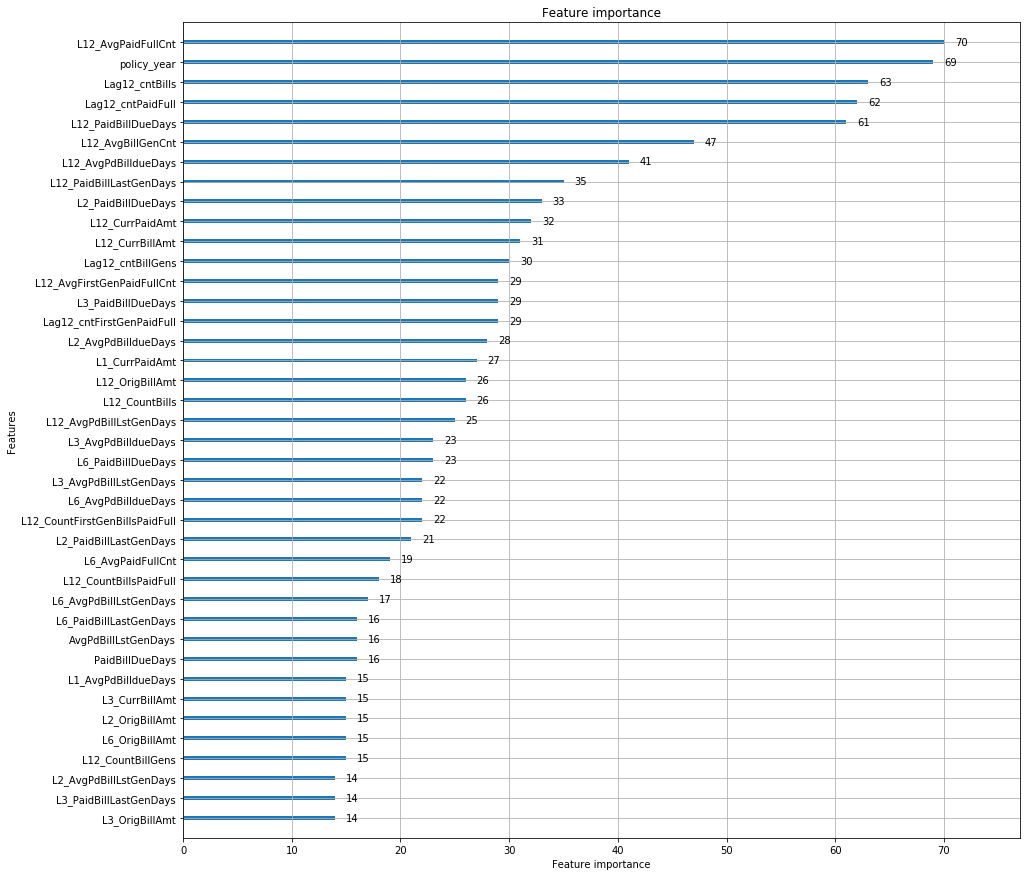

In [116]:
ax = lightgbm.plot_importance(model, max_num_features=40, figsize=(15,15))
plt.show()

In [117]:
df_feature_importance_v2 = (
    pd.DataFrame({
        'feature': model.feature_name(),
        'importance': model.feature_importance(),
    })
    .sort_values('importance', ascending=False)
)
df_feature_importance_v2["rank"]=list(range(len(model.feature_name())))
df_feature_importance_v2=df_feature_importance_v2.loc[:,["rank","feature","importance"]].reset_index(drop=True)
df_feature_importance_v2.head(20)

,rank,feature,importance
0,0,L12_AvgPaidFullCnt,70
1,1,policy_year,69
2,2,Lag12_cntBills,63
3,3,Lag12_cntPaidFull,62
4,4,L12_PaidBillDueDays,61
5,5,L12_AvgBillGenCnt,47
6,6,L12_AvgPdBilldueDays,41
7,7,L12_PaidBillLastGenDays,35
8,8,L2_PaidBillDueDays,33
9,9,L12_CurrPaidAmt,32


In [118]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_eval_v2=model_evaluate(y_train, train_preds)
test_eval_v2=model_evaluate(y_test, test_preds)

### Exclude rolling window aggregated variables

In [119]:
df3=df2.copy()
all_var=df3.columns.tolist()
exclude_var=[]
for col in all_var:
    if col[:2] in ["L1","L2","L3","L6","L12"]:
        exclude_var.append(col)
X_train.drop(exclude_var, axis=1,inplace=True)
X_test.drop(exclude_var, axis=1,inplace=True)
X_train.columns.tolist()

['policy_year',
 'CountBills',
 'CountBillGens',
 'CountFirstGenBillsPaidFull',
 'CountBillsPaidFull',
 'CountBillsPaid',
 'OrigBillAmt',
 'CurrBillAmt',
 'CurrPaidAmt',
 'PaidBillDueDays',
 'AvgPdBilldueDays',
 'PaidBillLastGenDays',
 'AvgPdBillLstGenDays',
 'AvgBillGenCnt',
 'AvgPaidFullCnt',
 'AvgFirstGenPaidFullCnt',
 'Lag12_cntBillGens',
 'Lag12_cntPaidFull',
 'Lag12_cntFirstGenPaidFull',
 'Lag12_cntBills',
 'paid_bill_prop']

In [120]:
# categorical_features=['year', 'month']
# train_data = lightgbm.Dataset(X_train, label=y_train,categorical_feature=categorical_features)
train_data = lightgbm.Dataset(X_train, label=y_train)
test_data = lightgbm.Dataset(X_test, label=y_test)
#basic parameter:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[1]	valid_0's auc: 0.491024
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.62631
[3]	valid_0's auc: 0.661318
[4]	valid_0's auc: 0.665839
[5]	valid_0's auc: 0.661926
[6]	valid_0's auc: 0.66128
[7]	valid_0's auc: 0.662208
[8]	valid_0's auc: 0.671485
[9]	valid_0's auc: 0.668582
[10]	valid_0's auc: 0.666628
[11]	valid_0's auc: 0.673142
[12]	valid_0's auc: 0.673413
[13]	valid_0's auc: 0.673379
[

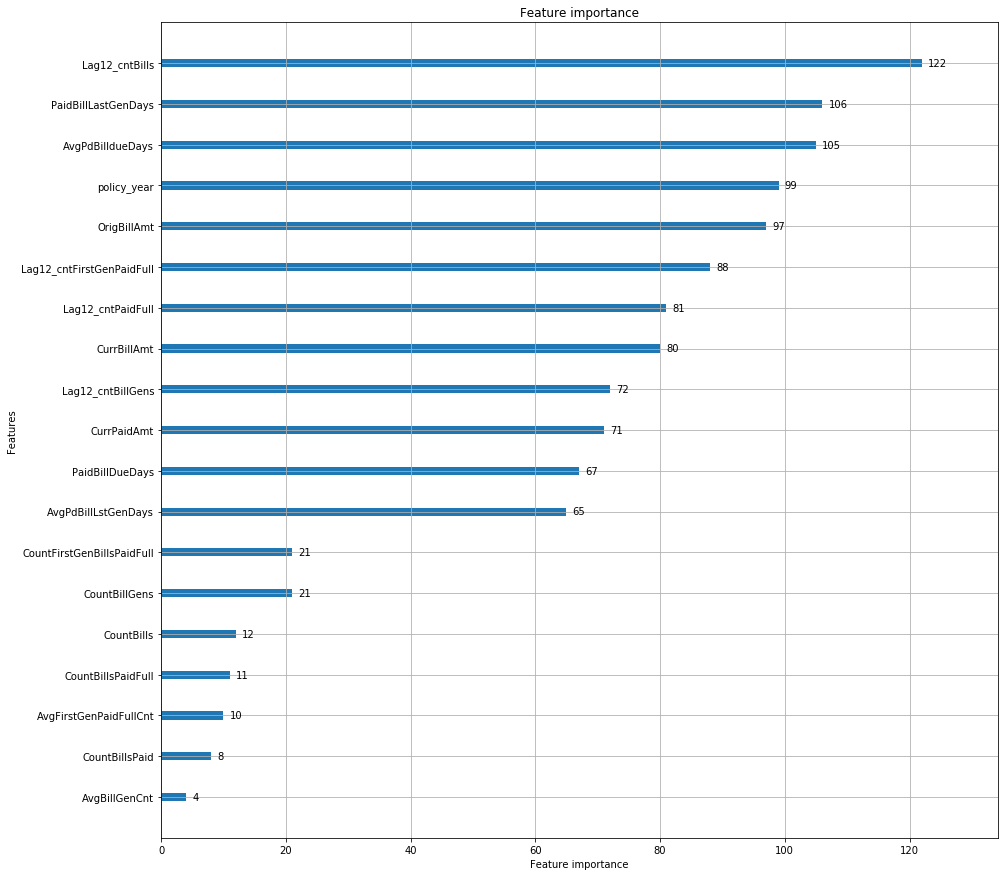

In [121]:
ax = lightgbm.plot_importance(model, max_num_features=40, figsize=(15,15))
plt.show()

In [122]:
df_feature_importance_v1 = (
    pd.DataFrame({
        'feature': model.feature_name(),
        'importance': model.feature_importance(),
    })
    .sort_values('importance', ascending=False)
)
df_feature_importance_v1["rank"]=list(range(len(model.feature_name())))
df_feature_importance_v1=df_feature_importance_v1.loc[:,["rank","feature","importance"]].reset_index(drop=True)
df_feature_importance_v1.head(20)

,rank,feature,importance
0,0,Lag12_cntBills,122
1,1,PaidBillLastGenDays,106
2,2,AvgPdBilldueDays,105
3,3,policy_year,99
4,4,OrigBillAmt,97
5,5,Lag12_cntFirstGenPaidFull,88
6,6,Lag12_cntPaidFull,81
7,7,CurrBillAmt,80
8,8,Lag12_cntBillGens,72
9,9,CurrPaidAmt,71


In [123]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_eval_v1=model_evaluate(y_train, train_preds)
test_eval_v1=model_evaluate(y_test, test_preds)

In [124]:
def evaluation_table(eval_v1,eval_v2,eval_v3,type):
    dict_data={}
    dict_data["Features"]=["Original feature","rolling window feature","rolling window + delta feature"]
    dict_data["# of feature"]=[len(feat_1),len(feat_2),len(feat_3)] 
    dict_data["# of sample"]=[eval_v1['nb_example'],eval_v2['nb_example'],eval_v3['nb_example']]
    # dict_data["true_prediction"]=[eval_v1['true_prediction'],eval_v2['true_prediction'],eval_v3['true_prediction']]
    # dict_data["false_prediction"]=[eval_v1['false_prediction'],eval_v2['false_prediction'],eval_v3['false_prediction']]
    # dict_data["accuracy"]=[eval_v1['accuracy'],eval_v2['accuracy'],eval_v3['accuracy']]
    dict_data["precision"]=[eval_v1['precision'],eval_v2['precision'],eval_v3['precision']]  
    dict_data["recall"]=[eval_v1['recall'],eval_v2['recall'],eval_v3['recall']] 
    dict_data["f1_score"]=[eval_v1['f1_score'],eval_v2['f1_score'],eval_v3['f1_score']] 
    dict_data["ROC-AUC"]=[eval_v1['AUC'],eval_v2['AUC'],eval_v3['AUC']] 
    dict_data["pr-auc"]=[eval_v1['pr_auc'],eval_v2['pr_auc'],eval_v3['pr_auc']] 
    data_df=pd.DataFrame(dict_data)
    # data_df=data_df.set_index("Model Type")
    # data_df.style.format({"# of sample":"{:,}","true_prediction":"{:,}","false_prediction":"{:,}","accuracy":"{:.2%}","precision":"{:.2%}","recall":"{:.2%}","f1_score":"{:.2%}","ROC-AUC":"{:.2%}","pr-auc":"{:.2%}"})\
    return data_df.style.format({"# of sample":"{:,}","precision":"{:.2%}","recall":"{:.2%}","f1_score":"{:.2%}","ROC-AUC":"{:.2%}","pr-auc":"{:.2%}"})\
    .set_caption(f"Model Performance Comparison {type}")\
    .set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'red'),
            ('font-size', '20px')
        ]
    }])

In [125]:
evaluation_table(train_eval_v1,train_eval_v2,train_eval_v3,"Training Set")

,Features,# of feature,# of sample,precision,recall,f1_score,ROC-AUC,pr-auc
0,Original feature,21,"206,569",14.72%,43.27%,21.97%,69.22%,15.08%
1,rolling window feature,21,"206,569",17.09%,42.43%,24.37%,73.16%,17.36%
2,rolling window + delta feature,21,"206,569",12.48%,71.99%,21.28%,70.42%,14.46%


In [126]:
evaluation_table(test_eval_v1,test_eval_v2,test_eval_v3,"Test Set")

,Features,# of feature,# of sample,precision,recall,f1_score,ROC-AUC,pr-auc
0,Original feature,21,"20,837",9.51%,52.84%,16.12%,69.66%,10.37%
1,rolling window feature,21,"20,837",9.50%,30.85%,14.52%,66.60%,8.60%
2,rolling window + delta feature,21,"20,837",7.22%,50.44%,12.63%,62.23%,18.41%


In [127]:
f1=df_feature_importance_v1.loc[:30,['rank','feature']].rename(columns={"feature":"original_feature"})
f2=df_feature_importance_v2.loc[:30,['rank','feature']].rename(columns={"feature":"Add rolling window feature"})
f3=df_feature_importance_v3.loc[:30,['rank','feature']].rename(columns={"feature":"Add Delta and Ratio feature"})

feature_importance=pd.merge(f1,f2,how="inner",on="rank")
feature_importance=pd.merge(feature_importance,f3,how="inner",on="rank")
# feature_importance.style.format().set_caption("Top 20 important Features").set_table_styles([{
#     'selector': 'caption',
#     'props': [
#         ('color', 'red'),
#         ('font-size', '20px')
#     ]
# }])
feature_importance

,rank,original_feature,Add rolling window feature,Add Delta and Ratio feature
0,0,Lag12_cntBills,L12_AvgPaidFullCnt,policy_year
1,1,PaidBillLastGenDays,policy_year,L12_AvgPaidFullCnt
2,2,AvgPdBilldueDays,Lag12_cntBills,r12_Lag12_cntBills
3,3,policy_year,Lag12_cntPaidFull,r6_Lag12_cntFirstGenPaidFull
4,4,OrigBillAmt,L12_PaidBillDueDays,d3_Lag12_cntBills
5,5,Lag12_cntFirstGenPaidFull,L12_AvgBillGenCnt,r1_Lag12_cntPaidFull
6,6,Lag12_cntPaidFull,L12_AvgPdBilldueDays,L12_AvgFirstGenPaidFullCnt
7,7,CurrBillAmt,L12_PaidBillLastGenDays,L6_OrigBillAmt
8,8,Lag12_cntBillGens,L2_PaidBillDueDays,L12_PaidBillDueDays
9,9,CurrPaidAmt,L12_CurrPaidAmt,r2_Lag12_cntPaidFull


In [128]:
dict_data={}
dict_data["Feature"]=["Original feature","Add rolling window feature","Add Delta and Ratio feature"]
dict_data["ROC_AUC"]=[test_eval_v1['AUC'],test_eval_v2['AUC'],test_eval_v3['AUC']]
dict_data["# of feature"]=[df_feature_importance_v1.shape[0],df_feature_importance_v2.shape[0],df_feature_importance_v3.shape[0]]  

data_df=pd.DataFrame(dict_data)
# data_df=data_df.set_index("Model Type")
data_df.style.format({"ROC_AUC":"{:.2%}"}).set_caption("")\
.set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'red'),
        ('font-size', '20px')
    ]
}])

,Feature,ROC_AUC,# of feature
0,Original feature,69.66%,21
1,Add rolling window feature,66.60%,101
2,Add Delta and Ratio feature,62.23%,301


In [129]:
df3=df2.copy()
# exclude_cols=['policy_id', 'pivot_date', 'churn']
# df3["year"]=df3["year"].astype('category')
# df3["month"]=df3["month"].astype('category')

exclude_cols=['policy_id', 'pivot_date', 'churn',"year","month"]

# target=df3.loc[:,["year","churn"]]
# feature=df3.drop(exclude_cols, axis=1)
# X_train,X_test,y_train,y_test=train_test_split(feature,target,test_size=0.25,stratify=target,random_state=101)

train_data=df3[df3["year"]!=2022]
test_data=df3[df3["year"]==2022]

y_train=train_data.loc[:,"churn"]
y_test=test_data.loc[:,"churn"]
X_train=train_data.drop(exclude_cols, axis=1)
X_test=test_data.drop(exclude_cols, axis=1)

# print("{:<30}{:<20,}".format('training features: ', len(X_train)))
# print("{:<30}{:<20,}".format('testing features: ', len(X_test)))
# # print("{:<30}{:<20,}".format('training features: ', len(y_train)))
# # print("{:<30}{:<20,}".format('testing features: ', len(y_test)))
# # print(y_train.value_counts(dropna=False,normalize=True).to_frame())
# pd.DataFrame(y_test, columns=["churn"])["churn"].value_counts(dropna=False,normalize=True).to_frame().style.format({"churn":"{:.2%}"})

feat_1=feature_importance["original_feature"].values.tolist()
feat_2=feature_importance["Add rolling window feature"].values.tolist()
feat_3=feature_importance["Add Delta and Ratio feature"].values.tolist()
feat_all=feat_1+feat_2+feat_3

In [130]:
train_data_v1 = lightgbm.Dataset(X_train.loc[:,feat_1], label=y_train)
test_data_v1 = lightgbm.Dataset(X_test.loc[:,feat_1], label=y_test)
#basic parameter:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = lightgbm.train(parameters,
                       train_data_v1,
                       valid_sets=test_data_v1,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[1]	valid_0's auc: 0.680402
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.664098
[3]	valid_0's auc: 0.645877
[4]	valid_0's auc: 0.654099
[5]	valid_0's auc: 0.673728
[6]	valid_0's auc: 0.666154
[7]	valid_0's auc: 0.671425
[8]	valid_0's auc: 0.666872
[9]	valid_0's auc: 0.677829
[10]	valid_0's auc: 0.682676
[11]	valid_0's auc: 0.686984
[12]	valid_0's auc: 0.686314
[13]	valid_0's auc: 0.687125

In [131]:
train_preds = model.predict(X_train.loc[:,feat_1])
test_preds = model.predict(X_test.loc[:,feat_1])

train_eval_v1=model_evaluate(y_train, train_preds)
test_eval_v1=model_evaluate(y_test, test_preds)

In [132]:
train_data_v2 = lightgbm.Dataset(X_train.loc[:,feat_2], label=y_train)
test_data_v2 = lightgbm.Dataset(X_test.loc[:,feat_2], label=y_test)
#basic parameter:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = lightgbm.train(parameters,
                       train_data_v2,
                       valid_sets=test_data_v2,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[1]	valid_0's auc: 0.506582
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.639127
[3]	valid_0's auc: 0.657608
[4]	valid_0's auc: 0.647842
[5]	valid_0's auc: 0.664412
[6]	valid_0's auc: 0.657858
[7]	valid_0's auc: 0.667447
[8]	valid_0's auc: 0.670245
[9]	valid_0's auc: 0.675667
[10]	valid_0's auc: 0.675412
[11]	valid_0's auc: 0.675785
[12]	valid_0's auc: 0.673693
[13]	valid_0's auc: 0.671365

In [133]:
train_preds = model.predict(X_train.loc[:,feat_2])
test_preds = model.predict(X_test.loc[:,feat_2])

train_eval_v2=model_evaluate(y_train, train_preds)
test_eval_v2=model_evaluate(y_test, test_preds)

In [134]:
train_data_v3 = lightgbm.Dataset(X_train.loc[:,feat_3], label=y_train)
test_data_v3 = lightgbm.Dataset(X_test.loc[:,feat_3], label=y_test)
#basic parameter:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = lightgbm.train(parameters,
                       train_data_v3,
                       valid_sets=test_data_v3,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[1]	valid_0's auc: 0.435783
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.525704
[3]	valid_0's auc: 0.604159
[4]	valid_0's auc: 0.60165
[5]	valid_0's auc: 0.609607
[6]	valid_0's auc: 0.611399
[7]	valid_0's auc: 0.604767
[8]	valid_0's auc: 0.622772
[9]	valid_0's auc: 0.613799
[10]	valid_0's auc: 0.606195
[11]	valid_0's auc: 0.617371
[12]	valid_0's auc: 0.610797
[13]	valid_0's auc: 0.60911
[

In [135]:
train_preds = model.predict(X_train.loc[:,feat_3])
test_preds = model.predict(X_test.loc[:,feat_3])

train_eval_v3=model_evaluate(y_train, train_preds)
test_eval_v3=model_evaluate(y_test, test_preds)

In [136]:
dict_data={}
dict_data["Feature"]=["Original feature","Add rolling window feature","Add Delta and Ratio feature"]
dict_data["ROC_AUC"]=[model_eval_v1['AUC'],model_eval_v2['AUC'],model_eval_v3['AUC']]
dict_data["# of feature"]=[len(feat_1),len(feat_2),len(feat_3)]  

data_df=pd.DataFrame(dict_data)
# data_df=data_df.set_index("Model Type")
data_df.style.format({"ROC_AUC":"{:.2%}"}).set_caption("")\
.set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'red'),
        ('font-size', '20px')
    ]
}])

NameError: name 'model_eval_v1' is not defined

In [ ]:
evaluation_table(train_eval_v1,train_eval_v2,train_eval_v3,"Training Set")

In [ ]:
evaluation_table(test_eval_v1,test_eval_v2,test_eval_v3,"Test Set")